In [2]:
import warnings
warnings.filterwarnings('ignore')

import torch
from transformers import RobertaTokenizer
from src import laion_clap


checkpoint_path = "/fs/nexus-scratch/milis/848K/CLAP/logs/reweighting_9_1e5_acaps_clotho/checkpoints/epoch_latest.pt"


model = laion_clap.CLAP_Module()
model.load_ckpt(checkpoint_path)
model.eval()


log_reweighting = model.model.text_branch.log_reweighting

tokenizer = RobertaTokenizer.from_pretrained("roberta-base")


def tokenize(text):
    token_ids = tokenizer.encode(text)
    tokens = tokenizer.convert_ids_to_tokens(token_ids)
    return token_ids, tokens

Initializing empty model here (0)


Some weights of the model checkpoint at roberta-base were not used when initializing CustomRobertaModel: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing CustomRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CustomRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CustomRobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'roberta.log_reweighting']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

Load the specified checkpoint /fs/nexus-scratch/milis/848K/CLAP/logs/reweighting_9_1e5_acaps_clotho/checkpoints/epoch_latest.pt from users.
Load Checkpoint...
Loaded state dict to memory (1)
Reweighting modules:
['text_branch.log_reweighting']
Loading state dict to model (2)
Loaded state dict to model strictly (3)


In [3]:
import matplotlib
import numpy as np
from IPython.display import HTML, display


def visualize_sentences(tokenized_sentences, token_weights):
    # Get colormap
    cmap = matplotlib.cm.get_cmap("OrRd")
    
    # Build HTML for each sentence
    sentence_html_list = []
    for tokens, weights in zip(tokenized_sentences, token_weights):
        # Normalize weights to [0, 1]
        weights = np.array(weights)
        norm_weights = (weights - min(weights)) / (max(weights) - min(weights))
        
        # Convert weights to colors
        colors = [matplotlib.colors.rgb2hex(cmap(w)) for w in norm_weights]

        print("Tokens:", tokens)
        print("Weights:", [round(w, 4) for w in weights])
        
        # Reconstruct the original sentence with token highlights
        highlighted_sentence = ""
        for i, token in enumerate(tokens):
            # Remove prefix indicators (e.g., ## or Ġ) for natural appearance
            if "##" in token or "Ġ" in token:
                token = " " + token.replace("Ġ", "")
            if token in ["<s>", "</s>"]:
                token = ""
            color = colors[i]
            highlighted_sentence += f'<span style="background-color:{color}; color:black; padding:0px; border-radius:3px; font-weight:bold;">{token}</span>'
        
        # Append the highlighted sentence to the list
        sentence_html_list.append(f"<li>{highlighted_sentence.strip()}</li>")
    
    # Combine all sentences into a single container with a white background
    html_content = f"""
    <div style='font-family:monospace; background-color:white; padding:10px;'>
        <ul style='list-style-type:none; padding:1px; margin:1px;'>
            {''.join(sentence_html_list)}
        </ul>
    </div>
    """
    display(HTML(html_content))
    return html_content


def visualize_data_driven(sentences):
    """
    sentences: list of strings
    """
    tokenized_sentences_list = []
    tokenized_weights_list = []

    for sentence in sentences:
        token_ids, tokens = tokenize(sentence)
        tokenized_sentences_list.append(tokens)

        log_weights = log_reweighting[token_ids]
        weights = torch.exp(log_weights).squeeze().tolist()
        tokenized_weights_list.append(weights)

    visualize_sentences(tokenized_sentences_list, tokenized_weights_list)


def visualize_user_driven(sentences, weights_list, sos_token="<s>", eos_token="</s>", default_weight=1.0):
    """
    sentences: list of strings
    weights: list of lists of floats
    """
    tokenized_sentences_list = []
    tokenized_weights_list = []

    for sentence, weights in zip(sentences, weights_list):
        words = sentence.split()
        # Initialize tokenized sentence and weights
        tokenized_sentence = []
        tokenized_weights = []

        # Add <SOS> token and its weight
        tokenized_sentence.append(sos_token)
        tokenized_weights.append(default_weight)

        # Process each word and its weight
        i = 0
        for word, weight in zip(words, weights):
            if i != 0:
                word = " " + word
            i += 1
            # Tokenize the word into subwords
            subwords = tokenize(word)[1][1:-1]

            # Extend tokenized sentence and replicate the weight for each subword
            tokenized_sentence.extend(subwords)
            tokenized_weights.extend([weight] * len(subwords))

        # Add <EOS> token and its weight
        tokenized_sentence.append(eos_token)
        tokenized_weights.append(default_weight)

        tokenized_sentences_list.append(tokenized_sentence)
        tokenized_weights_list.append(tokenized_weights)

    visualize_sentences(tokenized_sentences_list, tokenized_weights_list)

In [4]:
sentences = [
    "A dog barking loudly in the distance.",
    "Waves crashing on a sandy beach.",
    "The sound of a ticking clock in a quiet room.",
    "A baby crying softly.",
    "Footsteps echoing in an empty hallway.",
    "A train passing by with a loud horn.",
    "Birds chirping in the early morning.",
    "Rain falling gently on a metal roof.",
    "A door creaking as it slowly opens.",
    "The hum of an air conditioner in the background.",
    "A bustling coffee shop filled with the clinking of cups, faint chatter, and a barista steaming milk.",
    "The chaotic sound of traffic during rush hour, with honking horns and screeching brakes.",
    "A thunderstorm rolling in, with distant rumbles of thunder followed by heavy rain hitting the pavement.",
    "The crackling of a campfire, accompanied by occasional pops and the soft rustling of leaves in the wind.",
    "An orchestra tuning their instruments, creating a mix of violins, cellos, and wind instruments.",
    "The sound of a crowded market, vendors shouting prices, and shoppers bargaining amidst laughter.",
    "A forest at night, filled with crickets chirping, owls hooting, and the occasional rustle of leaves.",
    "The muffled sounds of music and laughter coming from a party next door.",
    "A construction site with jackhammers, drilling, and the beeping of reversing trucks.",
    "A small stream trickling over rocks, with birds softly singing in the background.",
    # "The sound of rain slowly intensifies, as if the sky itself is exhaling deeply.",
    # "A distant carnival, where laughter, music, and machinery mix into a surreal hum.",
    # "In a forest clearing, the breeze rustles leaves while an unseen bird calls out.",
    # "The muffled sound of footsteps on snow, accompanied by deep breaths in cold air.",
    # "An old vinyl record crackling and popping as it spins on a dusty player.",
    # "A lone car engine idling at a red light, with faint music seeping from its windows.",
    # "The rhythmic creak of a rocking chair in an otherwise silent room.",
    # "An empty train station where faint echoes suggest movement that isn't there.",
    # "The distant roar of waves, softened by the thick fog rolling in from the ocean.",
    # "The metallic clang of tools being dropped, followed by a muttered voice and silence.",
]


visualize_data_driven(sentences)


sentences = ["This is a testttt"]
weights = [[0.1, 0.2, 0.8, 0.3]]

visualize_user_driven(sentences, weights)

Tokens: ['<s>', 'A', 'Ġdog', 'Ġbarking', 'Ġloudly', 'Ġin', 'Ġthe', 'Ġdistance', '.', '</s>']
Weights: [1.0064, 0.9979, 0.9991, 1.0006, 1.0003, 0.9976, 0.9969, 0.9989, 0.9966, 1.005]
Tokens: ['<s>', 'W', 'aves', 'Ġcrashing', 'Ġon', 'Ġa', 'Ġsandy', 'Ġbeach', '.', '</s>']
Weights: [1.0064, 1.0013, 1.0008, 1.0006, 0.9996, 0.9955, 1.0005, 1.001, 0.9966, 1.005]
Tokens: ['<s>', 'The', 'Ġsound', 'Ġof', 'Ġa', 'Ġticking', 'Ġclock', 'Ġin', 'Ġa', 'Ġquiet', 'Ġroom', '.', '</s>']
Weights: [1.0064, 0.9984, 0.9982, 0.9991, 0.9955, 0.9998, 1.0007, 0.9976, 0.9955, 1.0, 0.9993, 0.9966, 1.005]
Tokens: ['<s>', 'A', 'Ġbaby', 'Ġcrying', 'Ġsoftly', '.', '</s>']
Weights: [1.0064, 0.9979, 1.002, 1.0016, 1.0005, 0.9966, 1.005]
Tokens: ['<s>', 'Foot', 'steps', 'Ġechoing', 'Ġin', 'Ġan', 'Ġempty', 'Ġhallway', '.', '</s>']
Weights: [1.0064, 1.0, 1.0003, 1.0005, 0.9976, 0.9994, 0.9995, 0.999, 0.9966, 1.005]
Tokens: ['<s>', 'A', 'Ġtrain', 'Ġpassing', 'Ġby', 'Ġwith', 'Ġa', 'Ġloud', 'Ġhorn', '.', '</s>']
Weights: [1.006

Tokens: ['<s>', 'This', 'Ġis', 'Ġa', 'Ġtest', 'tt', 't', '</s>']
Weights: [1.0, 0.1, 0.2, 0.8, 0.3, 0.3, 0.3, 1.0]


In [5]:
import pandas as pd


sentences = pd.read_csv(
    "/fs/cbcb-scratch/milis/data/audiocaps/val.csv"
)["caption"].sample(n=10)

visualize_data_driven(sentences)

Tokens: ['<s>', 'People', 'Ġspeak', 'Ġand', 'Ġchildren', 'Ġlaugh', '</s>']
Weights: [1.0064, 0.9973, 0.9985, 0.9955, 1.0017, 0.9999, 1.005]
Tokens: ['<s>', 'A', 'Ġman', 'Ġspeaks', 'Ġand', 'Ġwind', 'Ġblows', 'Ġas', 'Ġan', 'Ġaircraft', 'Ġengine', 'Ġbecomes', 'Ġlouder', '</s>']
Weights: [1.0064, 0.9979, 0.9974, 0.9999, 0.9955, 1.0032, 1.002, 0.9987, 0.9994, 1.0015, 1.0039, 0.9994, 0.9984, 1.005]
Tokens: ['<s>', 'A', 'Ġman', 'Ġspeaks', 'Ġwhile', 'Ġusing', 'Ġan', 'Ġold', 'Ġphone', 'Ġpunching', 'Ġin', 'Ġthe', 'Ġnumbers', 'Ġon', 'Ġthe', 'Ġdial', '</s>']
Weights: [1.0064, 0.9979, 0.9974, 0.9999, 0.9977, 1.0001, 0.9994, 1.0004, 0.9998, 0.9994, 0.9976, 0.9969, 0.9997, 0.9996, 0.9969, 1.0004, 1.005]
Tokens: ['<s>', 'The', 'Ġwind', 'Ġbl', 'ares', 'Ġloudly', 'Ġas', 'Ġcars', 'Ġspeed', 'Ġby', 'Ġand', 'Ġclothing', 'Ġfl', 'aps', 'Ġin', 'Ġthe', 'Ġwind', '</s>']
Weights: [1.0064, 0.9984, 1.0032, 1.0008, 1.0005, 1.0003, 0.9987, 0.9998, 0.9985, 1.0009, 0.9955, 1.0001, 1.0011, 0.9999, 0.9976, 0.9969, 1.0032

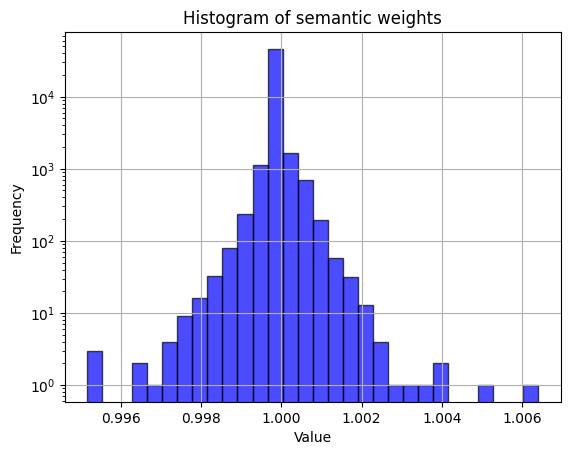

In [11]:
import matplotlib.pyplot as plt


plt.figure()
plt.hist(torch.exp(log_reweighting).detach().numpy(), bins=30, color='blue', alpha=0.7, edgecolor='black', log=True)
plt.title("Histogram of semantic weights")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.grid(True)
plt.savefig("plots/weights_hist.png", dpi=200, bbox_inches="tight")